### Model Info: loss: loss: 0.1195 - accuracy: 0.9512 - val_loss: 0.1865 - val_accuracy: 0.9396
Data: Grid

ImageDataGenerator( \
    rescale=1. / 255, \
    shear_range=0.2, \
    zoom_range=0.2, \
    horizontal_flip=True)
   
batch_size = 64 \
image_width = 224 \
image_height = 224 
    
optimizer='rmsprop
epochs=20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime, os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [ ]:
# from keras.applications import VGG16

# # include top should be False to remove the softmax layer
# pretrained_model = VGG16(include_top=False, weights='imagenet')
# pretrained_model.summary()

### Extracting data from the following source

In [2]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"

--2022-04-08 19:34:58--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2022-04-08 19:34:58--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf9f607d7366e7fe333ab30fd8.dl.dropboxusercontent.com/cd/0/inline/BjAS6faJrtKzOshDApZ2l88dIiXenoV7UzdV9zAKbdJskHqe2ppUI7betld4ieCdXAiG4yuE8CXSKBuGE2l_M6rGJORe16N4oQeeD7E-mbusbaKEtBy3uq1ljZcr3FmkB_O1g4NLx0lPE6rQhfkpCohO5Qr-0BuR_ocL0xEu5kHbDQ/file# [following]
--2022-04-08 19:34:58--  https://ucbf9f607d7366e7fe333ab30fd8.dl.dropboxusercontent.com/cd/0/inline/BjAS6faJrtKzOshDApZ2l88dIiXenoV7UzdV9zAKbdJskHqe2ppUI7be

#### Unzip data to directory

In [3]:
!tar -xvf 'grid_version.tar'

grid_version/
grid_version/validate/
grid_version/.DS_Store
grid_version/train/
grid_version/train/grid_no_smoke/
grid_version/train/.DS_Store
grid_version/train/grid_smoke/
grid_version/train/grid_smoke/1529002100_+01140_05_03.png
grid_version/train/grid_smoke/1529003240_+02280_05_03.png
grid_version/train/grid_smoke/1499547403_+01140_03_06.png
grid_version/train/grid_smoke/1499547763_+01500_05_07.png
grid_version/train/grid_smoke/1529002880_+01920_05_03.png
grid_version/train/grid_smoke/1528759446_+02040_06_08.png
grid_version/train/grid_smoke/1528759506_+02100_06_04.png
grid_version/train/grid_smoke/1498418253_+01860_05_08.png
grid_version/train/grid_smoke/1498418493_+02100_04_09.png
grid_version/train/grid_smoke/1529001560_+00600_06_04.png
grid_version/train/grid_smoke/1499547283_+01020_04_06.png
grid_version/train/grid_smoke/1528759686_+02280_05_06.png
grid_version/train/grid_smoke/1529022805_+02100_05_05.png
grid_version/train/grid_smoke/1530740065_+01020_04_07.png
grid_version/t

In [4]:
train_input_folder ='grid_version/train'
validate_input_folder = 'grid_version/validate'

In [5]:
# Install for following function
!pip install imutils

In [22]:
from imutils import paths
import os
import shutil
import random

def split_data(directory, validate_directory='validation', split=0.8): 
    directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
    print(directories)
    
    for directory in directories:
        image_paths = list(paths.list_images(directory))
    
        random.seed(32)
        random.shuffle(image_paths)
        image_paths

        # compute the training and testing split
        i = int(len(image_paths) * split)
        
        print(len(image_paths) - i)
        train_paths = image_paths[:i]
        selected_for_validation_paths = image_paths[i:]

        new_train_dir = './sampled_train'
        new_val_dir = './sampled_validate'

        if os.path.isdir(new_train_dir) is False:
            os.makedirs(new_train_dir)
            os.makedirs(new_val_dir)

        for path in selected_for_validation_paths:
            category = os.path.basename(os.path.normpath(directory))
            # print(category)
            dest_path = os.path.join(new_val_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)

        for path in train_paths:
            category = os.path.basename(os.path.normpath(directory))
            # print(category)
            dest_path = os.path.join(new_train_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
            shutil.copy(path, dest_path)  

In [23]:
split_data(directory='grid_version/train/', validate_directory='grid_version/validation')  

['grid_version/train/grid_no_smoke', 'grid_version/train/grid_smoke']
525
200


In [8]:
train_path = 'sampled_train'
test_path = 'sampled_validate'

### Image Augmentation
**Preprocessing Function-** 

**preprocessing_function** = preprocess_input will convert the input images from RGB to BGR, \
then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

**rescale** = scales images

**shear_range** = Shear transformation slants the shape of the image. This is different from rotation \
in the sense that in shear transformation, we fix one axis and stretch the image at a certain angle \
known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. \
shear_range specifies the angle of the slant in degrees.

**zoom_range** = A random zoom is obtained by the zoom_range argument. \
A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 zooms out of the image.

**horizonatal_flip** = The generator will generate images, which on a random basis, will be horizontally flipped.


In [9]:
#apply image augmentation
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
"""ImageDataGenerator(
    rescale=1./255)"""
    
test_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [10]:
# Variables for model
batch_size = 64
image_width = 224 
image_height = 224 
classes = ['grid_no_smoke','grid_smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

#create train data generator flowing from `grid_version/train` folder
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
#create validation data generator flowing from `grid_version/validate` folder
test_generator = test_image_generator.flow_from_directory(
        test_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

Found 2896 images belonging to 2 classes.
Found 725 images belonging to 2 classes.


##### Check if there are any identical images between the `sampled_train` and `sampled_validate` folders (`grid_smoke` vs `grid_smoke` | `grid_no_smoke` vs `grid_no_smoke`)
Any identical images will be be printed out; therefore, zero outputs are the intended behavior.

In [15]:
!diff -srq sampled_validate/grid_smoke/ sampled_train/grid_smoke/ | grep identical

In [16]:
!diff -srq sampled_validate/grid_no_smoke/ sampled_train/grid_no_smoke/ | grep identical

##### Plot out a sample of images

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

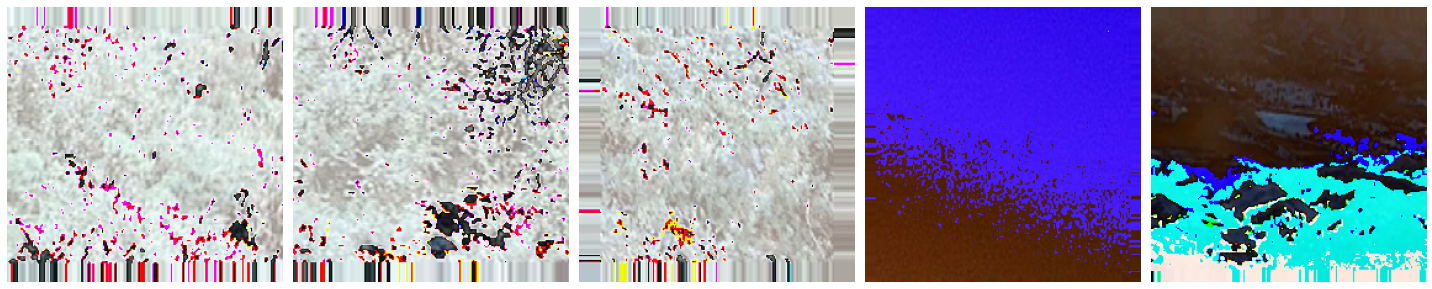

In [18]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:100])

### Neural Network

In [19]:
input_shape = (image_width, image_height, 3)

In [20]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


2022-04-08 19:41:43.660146: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator,
      validation_steps=test_steps,
      epochs=epochs,
      callbacks=[tensorboard_callback])

Epoch 1/10
45/45 [==============================] - 95s 2s/step - loss: 0.4342 - accuracy: 0.7775 - val_loss: 0.3162 - val_accuracy: 0.9148
Epoch 2/10
45/45 [==============================] - 92s 2s/step - loss: 0.3029 - accuracy: 0.8757 - val_loss: 0.2465 - val_accuracy: 0.9105
Epoch 3/10
45/45 [==============================] - 91s 2s/step - loss: 0.2712 - accuracy: 0.9145 - val_loss: 0.1859 - val_accuracy: 0.9574
Epoch 4/10
45/45 [==============================] - 92s 2s/step - loss: 0.2279 - accuracy: 0.9273 - val_loss: 0.1715 - val_accuracy: 0.9446
Epoch 5/10
45/45 [==============================] - 92s 2s/step - loss: 0.2118 - accuracy: 0.9336 - val_loss: 0.1447 - val_accuracy: 0.9659
Epoch 6/10
45/45 [==============================] - 92s 2s/step - loss: 0.2085 - accuracy: 0.9407 - val_loss: 0.1113 - val_accuracy: 0.9716
Epoch 7/10
45/45 [==============================] - 92s 2s/step - loss: 0.1925 - accuracy: 0.9453 - val_loss: 0.1140 - val_accuracy: 0.9645
Epoch 8/10
45/45 [==

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

Text(0.5, 0, 'epoch')

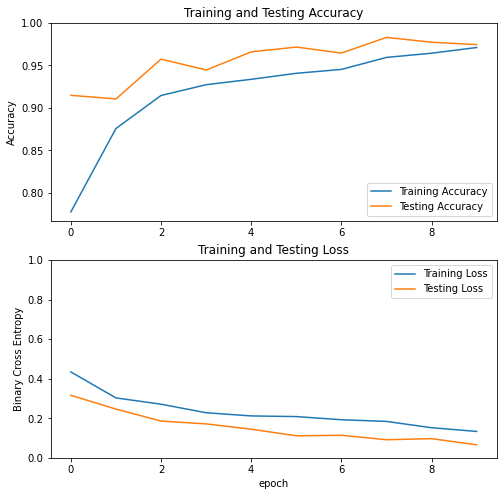

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')

### Predictions
Not sure what I need to do here... still trying to figure this out!

In [42]:
# This doesn't work...
# model.evaluate(train_generator, test_generator)

In [35]:
pred = model.predict(test_generator, verbose=1)

12/12 [==============================] - 5s 408ms/step


In [30]:
pred.shape

(725, 1)

In [ ]:
train_generator.seed

In [43]:
train_generator.num_classes

2

In [ ]:
train_generator.

In [44]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [46]:
predictions = model.predict(x=test_generator, steps=len(test_generator), verbose=1)

12/12 [==============================] - 5s 368ms/step


In [48]:
np.round(predictions)

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],

In [45]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

hand drawn picture of smoke

cauliflower on marble tap top / brocolli

tree picture